# Pyomo.DoE: Optimization

Our [earlier exploratory analysis](./doe_exploratory_analysis.ipynb) showed the sine wave experiment alone is rank deficient. What if instead of optimizing the sine wave parameters $a$ and $p$, we directly optimize $u(t)$. In other words, we will formulate model-based design of experiments as an [optimal control problem](./pyomo_simulation.ipynb).

Maximize a scalar-valued function $\psi(\cdot)$ of the Fisher information matrix $\mathbf{M}$:

$$
\begin{align*}
\max_{u} \quad & \psi(\mathbf{M}(u) + \mathbf{M}_0) \\
\mathrm{s.t.} \quad & C_p^H \frac{dT_H}{dt} = U_a (T_{amb} - T_H) + U_b (T_S - T_H) + \alpha P u(t)\\
& C_p^S \frac{dT_S}{dt} = U_b (T_H - T_S)  \\
& 0\% \leq u(t) \leq 100 \% \\
& T_H(t_0) = T_{amb} \\
& T_S(t_0) = T_{amb}
\end{align*}
$$

`Pyomo.DoE` automatically formulates, initializes, and solves this optimization problem for $\psi(\cdot) = \log_{10}(\mathrm{trace}(\cdot))$, i.e., A-optimality, and $\psi(\cdot) = \log_{10}(\mathrm{det}(\cdot))$, i.e., D-optimality.

In [1]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TC_Lab_data,
    TC_Lab_experiment,
    extract_results,
    extract_plot_results,
    results_summary,
)

# set default number of states in the TCLab model
number_tclab_states = 2

!pyomo --version

Pyomo 6.9.2.dev0 (devel {pyomo-doe-fix-initialization}) (CPython 3.11.11 on Darwin 24.3.0)


## Load experimental data (sine test)

We will load the sine test data to serve as an initial point. Recall our create model function will use supplied data to initialize the Pyomo model. Carefully initialization is often required for optimization of large-scale dynamic systems.

In [2]:
import pandas as pd

if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_sine_test_5min_period.csv"
else:
    file = '../data/tclab_sine_test_5min_period.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,22.2,22.2,50,0
1,1.01,22.2,22.2,51,0
2,2.01,22.2,22.2,52,0
3,3.00,22.2,22.2,53,0
4,4.01,22.2,22.2,54,0


For completeness, we will visualize the data again.

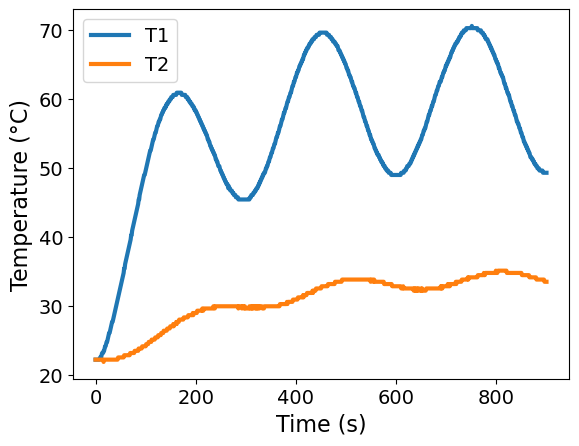

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

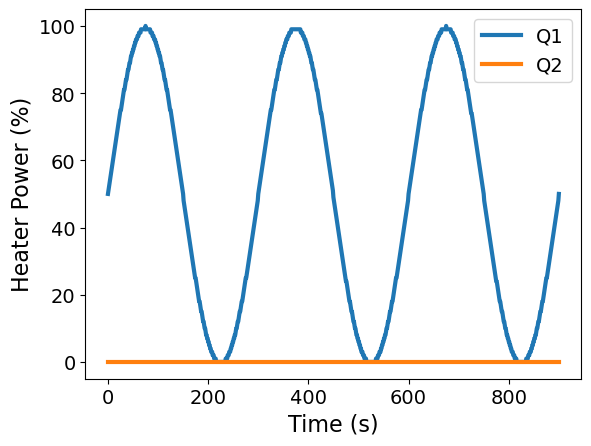

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

And then we will store the data in an instance of our `TC_Lab_data` dataclass.

In [5]:
# Here, we will induce a step size of 6 seconds, as to not give too many 
# degrees of freedom for experimental design.
skip = 6

# Create the data object considering the new control points every 6 seconds
tc_data = TC_Lab_data(
    name="Sine Wave Test for Heater 1",
    time=df['Time'].values[::skip],
    T1=df['T1'].values[::skip],
    u1=df['Q1'].values[::skip],
    P1=200,
    TS1_data=None,
    T2=df['T2'].values[::skip],
    u2=df['Q2'].values[::skip],
    P2=200,
    TS2_data=None,
    Tamb=df['T1'].values[0],
)

## Calculate FIM at initial point (sine test)

We will start computing the FIM of the sine test experiment.

In [6]:
# Load Pyomo.DoE class
from pyomo.contrib.doe import DesignOfExperiments

from pyomo.environ import SolverFactory

# Copied from previous notebook
theta_values = {
    'Ua': 0.0417051733576387,
    'Ub': 0.009440714239773074,
    'inv_CpH': 0.1659093525658045,
    'inv_CpS': 5.8357556063605465,
}

In [7]:
# Create experiment object for design of experiments
doe_experiment = TC_Lab_experiment(data=tc_data, theta_initial=theta_values, number_of_states=number_tclab_states)

# Create the design of experiments object using our experiment instance from above
TC_Lab_DoE = DesignOfExperiments(experiment=doe_experiment, 
                                 step=1e-3,
                                 scale_constant_value=1,
                                 scale_nominal_param_value=True, 
                                 tee=True,)

FIM = TC_Lab_DoE.compute_FIM(method='sequential')

Finally, we will look at the eigendecomposition using the helper function `results_summary` defined in `tclab_pyomo.py`.

In [8]:
results_summary(FIM)

======Results Summary======
Four design criteria log10() value:
A-optimality: 5.77235362993148
D-optimality: 1.4125806762567479
E-optimality: -12.645657334813103
Modified E-optimality: 17.58171609153067

FIM:
 [[517161.86070188   1456.96178404 -64374.44701689   -683.42545522]
 [  1456.96178404   4983.24928739  12321.60975223   5221.84255908]
 [-64374.44701689  12321.60975223  64390.68613421  14014.54073623]
 [  -683.42545522   5221.84255908  14014.54073623   5507.72097114]]

eigenvalues:
 [5.26149915e+05 6.20785255e+04 3.81507676e+03 2.26121920e-13]

eigenvectors:
 [[ 9.90386097e-01  1.31468307e-01 -4.30286214e-02 -2.87261085e-09]
 [-5.49941323e-04  2.27349847e-01  6.81979724e-01 -6.95136965e-01]
 [-1.38238232e-01  9.31879761e-01 -3.34581204e-01 -2.33606522e-02]
 [-5.02662316e-03  2.50256352e-01  6.48928048e-01  7.18497654e-01]]


## Optimize next experiment (D-optimality)

We are now ready to solve the optimization problem! Notice we create a new `DesignOfExperiments` object and specify the `prior_FIM` as result for the sine wave test. Thus we are decided what is the next best experiment to conduct. We already completed to sine test; we should use the data!

In [9]:
# Create experiment object for design of experiments
doe_experiment = TC_Lab_experiment(data=tc_data, theta_initial=theta_values, number_of_states=number_tclab_states)

# Create the design of experiments object using our experiment instance from above
TC_Lab_DoE_D = DesignOfExperiments(experiment=doe_experiment, 
                                 step=1e-3,
                                 scale_constant_value=1,
                                 scale_nominal_param_value=True,
                                 objective_option="determinant",  # Now we specify a type of objective, D-opt = "determinant"
                                 prior_FIM=FIM,  # We use the prior information from the existing experiment!
                                 tee=True,)

TC_Lab_DoE_D.run_doe()

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

Now let's visualize the optimal experiment.

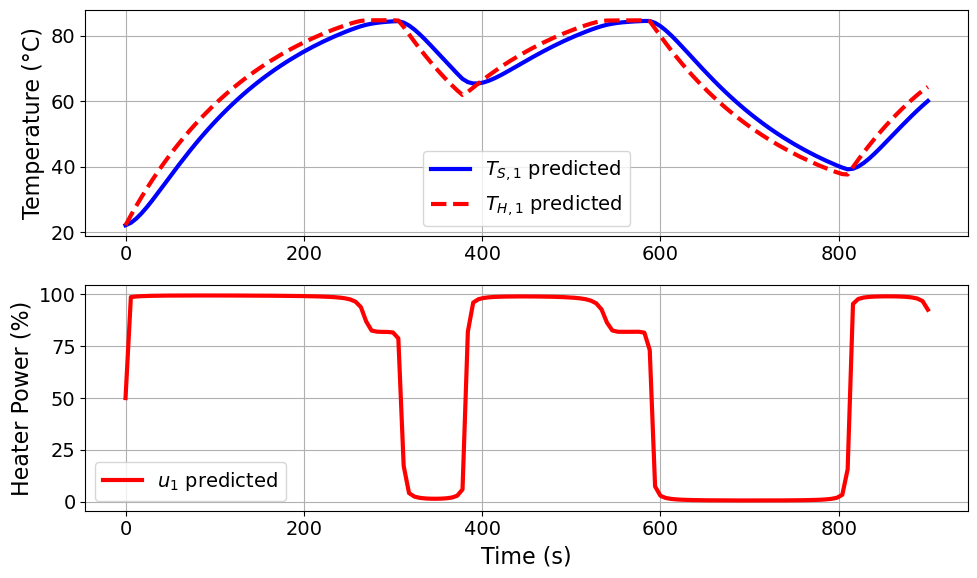

Model parameters:
Ua = 0.0417 Watts/degC
Ub = 0.0094 Watts/degC
CpH = 6.0274 Joules/degC
CpS = 0.1714 Joules/degC
 


In [10]:
dopt_pyomo_doe_results = extract_plot_results(None, TC_Lab_DoE_D.model.scenario_blocks[0])

Fascinating. The D-optimal experiment is close to a square wave that fluctuates between maximum power and off. The square wave transitions from full power to off when the predicted sensor temperature reaches ~85 °C. Likewise, the heater turns back on when the sensor cools to ~60 °C. Then the following cycle allows the sensor to return to 40 °C. This experiment captures two cooling cycles and almost three full heating events.

Finally, let's analyze the predicted FIM of the new optimized experiment plus the existing sine wave experiment.

In [11]:
results_summary(TC_Lab_DoE_D.results['FIM'])

======Results Summary======
Four design criteria log10() value:
A-optimality: 6.2357942741934345
D-optimality: 4.3635898572057386
E-optimality: -11.22081815875421
Modified E-optimality: 17.33879769314223

FIM:
 [[np.float64(1489259.1387169936), np.float64(9080.625425766484), np.float64(-118643.059463048), np.float64(4927.926820479291)], [np.float64(9080.625425766484), np.float64(11940.221077625447), np.float64(34855.77159974513), np.float64(12685.27828219668)], [np.float64(-118643.059463048), np.float64(34855.77159974513), np.float64(206266.44646302835), np.float64(40428.87772594578)], [np.float64(4927.926820479291), np.float64(12685.27828219668), np.float64(40428.87772594578), np.float64(13587.310717389622)]]

eigenvalues:
 [1.50016242e+06 2.11114780e+05 9.77591235e+03 6.01425505e-12]

eigenvectors:
 [[ 9.95826357e-01  8.66424717e-02 -2.86870763e-02 -3.13280796e-09]
 [ 3.94797957e-03  1.84652369e-01  6.94746365e-01 -6.95136968e-01]
 [-9.11786624e-02  9.56245784e-01 -2.77010346e-01 -2.

Success. The FIM of the new optimized experiment and the existing sine wave experiment is not rank deficient! We see from the eigendecomposition we still have the least information about parameter $C_p^S$. However, these results suggest we can uniquely estimate all four parameters using just two experiments.

## Optimize next experiment (A-optimality)

Next, we will consider A-optimality.

In [12]:
# Create experiment object for design of experiments
doe_experiment = TC_Lab_experiment(data=tc_data, theta_initial=theta_values, number_of_states=number_tclab_states)

# Create the design of experiments object using our experiment instance from above
TC_Lab_DoE_A = DesignOfExperiments(experiment=doe_experiment, 
                                 step=1e-2,
                                 scale_constant_value=1,
                                 scale_nominal_param_value=True,
                                 objective_option="trace",  # Now we specify a type of objective, A-opt = "trace"
                                 prior_FIM=FIM,  # We use the prior information from the same existing experiment as in the D-optimal case!
                                 tee=True,)

TC_Lab_DoE_A.run_doe()

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

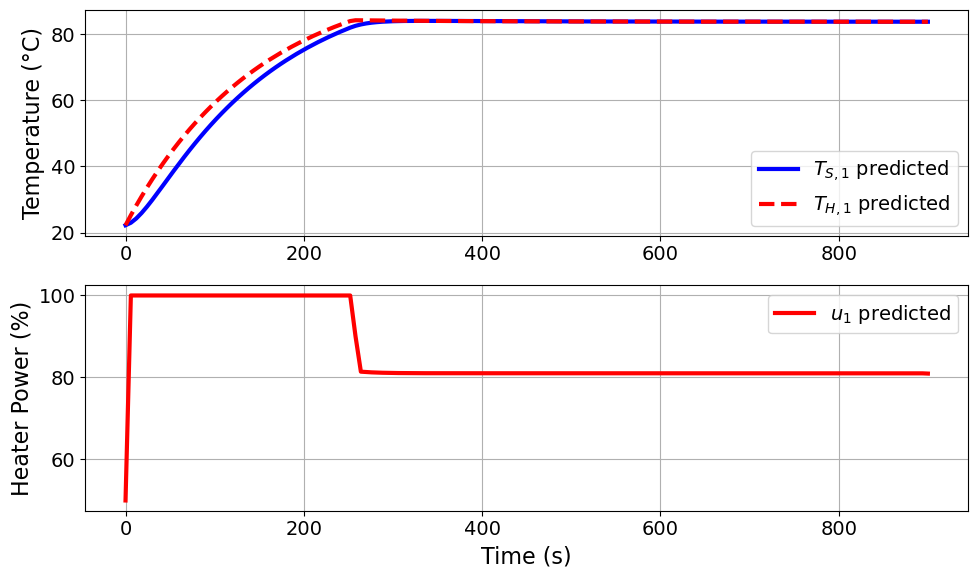

Model parameters:
Ua = 0.0421 Watts/degC
Ub = 0.0094 Watts/degC
CpH = 6.0274 Joules/degC
CpS = 0.1714 Joules/degC
 


In [13]:
dopt_pyomo_doe_results = extract_plot_results(None, TC_Lab_DoE_A.model.scenario_blocks[0])

Interestingly, we get a different optimal experiment. However, square-tooth like structure appears to emulate the first cycle in the D-optimal experiment, however achieving a higher temperature appears to be the best experiment for the A-optimal criteria.

In [14]:
results_summary(TC_Lab_DoE_A.results['FIM'])

======Results Summary======
Four design criteria log10() value:
A-optimality: 6.33245914238868
D-optimality: 8.184259191207587
E-optimality: -7.069851376847177
Modified E-optimality: 13.368886488651802

FIM:
 [[np.float64(1955801.6476194405), np.float64(-10159.719650768557), np.float64(-250758.20984453775), np.float64(-17982.211543028476)], [np.float64(-10159.719650768557), np.float64(8229.350957585959), np.float64(27870.222181139266), np.float64(8867.959453944148)], [np.float64(-250758.20984453775), np.float64(27870.222181139266), np.float64(176428.53727510473), np.float64(32700.48361347597)], [np.float64(-17982.211543028476), np.float64(8867.959453944148), np.float64(32700.48361347597), np.float64(9642.856367472783)]]

eigenvalues:
 [1.99081403e+06 1.53410207e+05 5.87815112e+03 8.51429362e-08]

eigenvectors:
 [[-9.90454211e-01  1.35339183e-01 -2.61488263e-02 -2.00597321e-07]
 [ 7.05471104e-03  1.85795748e-01  6.94418009e-01 -6.95135814e-01]
 [ 1.37198076e-01  9.50152840e-01 -2.789990

## Sensitivity Analysis

The eigendecomposition of the FIM above shows we have the least information (and thus greatest uncertainty) about parameter $C_p^S$. In fact, notice that $C_p^S$ goes to its bound in our earlier [parameter estimation](./parmest.ipynb) analysis.

This uncertainty motivates performing a sensivitiy analysis of the optimal experiment design to perturbations in $C_p^S$. The code below focuses on A-optimality because it is computational less expensive, but and can easily adapted to D-optimality by changing the `objective_option`.

In [15]:
import numpy as np

CpS_values = np.array([0.01, 0.05, 0.1, 0.5, 1.0])
a_opt = np.zeros((len(CpS_values)))
u_solutions = np.zeros((len(CpS_values), len(tc_data.time)))
Ts_solutions = np.zeros((len(CpS_values), len(tc_data.time)))

for i, v in enumerate(CpS_values):

    print("\n********************\nCpS = ", v, " J/°C")

    theta_values_new = theta_values.copy()
    theta_values_new['inv_CpS'] = 1 / v

    # Create experiment object for design of experiments
    doe_experiment = TC_Lab_experiment(data=tc_data, theta_initial=theta_values_new, number_of_states=number_tclab_states)
    
    # Create the design of experiments object using our experiment instance from above
    TC_Lab_DoE = DesignOfExperiments(experiment=doe_experiment, 
                                     step=1e-2,
                                     scale_constant_value=1,
                                     scale_nominal_param_value=True, 
                                     tee=False,)

    FIM_new = TC_Lab_DoE.compute_FIM(method='sequential')

    # Create a new DoE object
    TC_Lab_DoE = DesignOfExperiments(experiment=doe_experiment, 
                                     step=1e-2,
                                     scale_constant_value=1,
                                     scale_nominal_param_value=True,
                                     objective_option="trace",  # We specify a type of objective, A-opt = "trace"
                                     prior_FIM=FIM,  # We use the prior information from the original experiment
                                     tee=False,)
    
    TC_Lab_DoE.run_doe()

    
    pyomo_results = extract_results(TC_Lab_DoE.model.scenario_blocks[0])

    results_summary(TC_Lab_DoE.results['FIM'])

    a_opt[i] = np.log10(np.trace(TC_Lab_DoE.results['FIM']))
    u_solutions[i, :] = pyomo_results.u1
    Ts_solutions[i, :] = pyomo_results.TS1_data

    print("********************\n")


********************
CpS =  0.01  J/°C
======Results Summary======
Four design criteria log10() value:
A-optimality: 6.3453866557504774
D-optimality: 16.468701983582413
E-optimality: 1.0901328477478047
Modified E-optimality: 5.222993800742164

FIM:
 [[np.float64(2022763.13897065), np.float64(926.8448171012095), np.float64(-251428.51500115817), np.float64(-1525.2723856051714)], [np.float64(926.8448171012095), np.float64(4997.270701023987), np.float64(13210.212814955763), np.float64(5237.325821127063)], [np.float64(-251428.51500115817), np.float64(13210.212814955763), np.float64(181780.5235970441), np.float64(15097.868670639717)], [np.float64(-1525.2723856051714), np.float64(5237.325821127063), np.float64(15097.868670639717), np.float64(5524.989109177763)]]

eigenvalues:
 [2.05649022e+06 1.50856519e+05 7.70687658e+03 1.23064516e+01]

eigenvectors:
 [[-9.91122239e-01 -1.31852397e-01  1.70770001e-02  1.71786742e-04]
 [ 4.12659296e-04 -9.34503584e-02 -6.90368250e-01 -7.17397058e-01]
 [ 1.3

Now let's visualize how the *A-optimality objective* changes as a function of $C_p^S$.

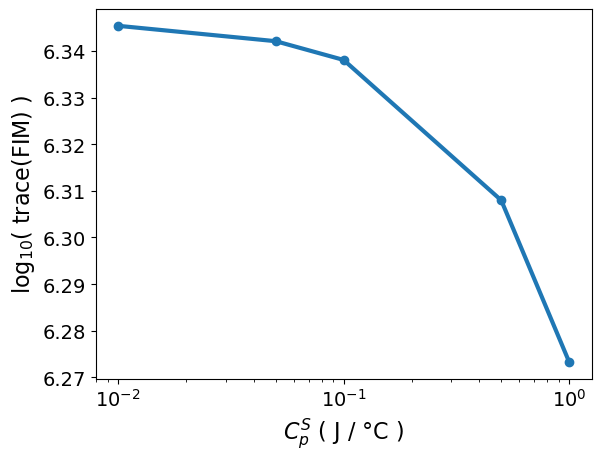

In [16]:
import matplotlib.pyplot as plt

plt.semilogx(CpS_values, a_opt, marker='o')
plt.xlabel('$C_p^S$ ( J / °C )')
plt.ylabel('log$_{10}$( trace(FIM) )')
plt.show()

We see the objective changes insignificantly as we vary $C_p^S$. What about the optimal solution?

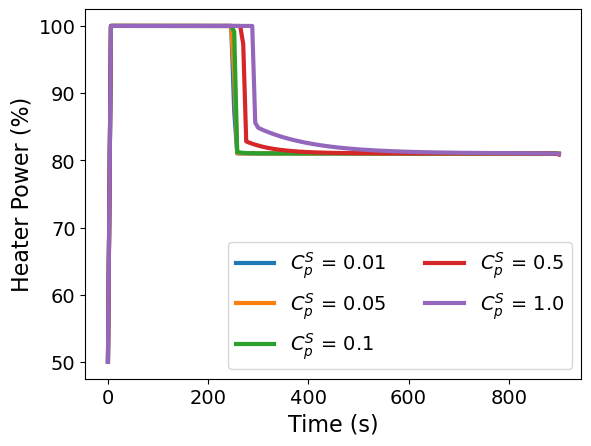

In [17]:
for i, v in enumerate(CpS_values):
    plt.plot(tc_data.time, u_solutions[i, :], label=f'$C_p^S$ = {v}')
plt.legend(ncol=2, loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Heater Power (%)')
plt.show()

Interesting, the A-optimal next experiment does change on the assumed value of $C_p^S$. For small values of $C_p^S$, the optimal solutions are similar: start around $u_1 = 100$% and then decreases as the experiment progresses. As $C_p^S$ increases, the length of time spent at 100% power increases.

Let's also look at the optimal sensor temperature profile:

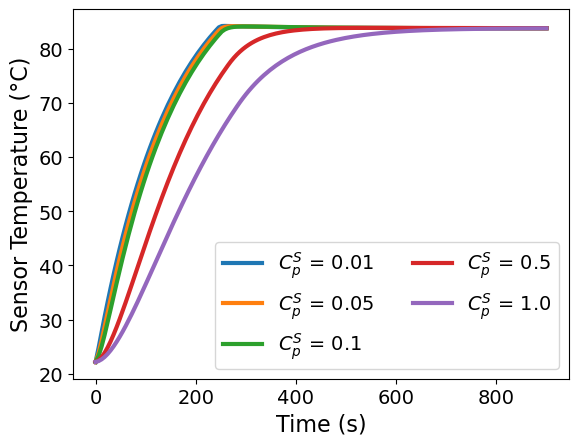

In [18]:
for i, v in enumerate(CpS_values):
    plt.plot(tc_data.time, Ts_solutions[i, :], label=f'$C_p^S$ = {v}')
plt.legend(ncol=2, loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Sensor Temperature (°C)')
plt.show()

Now to be pragmatic. What should we do with this information? Here are some suggested next steps:
- Confirm that these optimal experiments are all very informative for all of the values of $C_p^S$. If this is the case, we can pick on, perform the experiment, and then refit our model.
- Explore alternate formulations of MBDoE that consider uncertainty. We are working on a major overhaul of Pyomo.DoE that will make this much easier.